In [ ]:
!pip install imutils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#Modules for VGG19
import cv2
import imutils
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical

#Modules for InceptionV3
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras import regularizers

# Import necessary libraries
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input, GlobalAveragePooling2D, Dense, concatenate
from keras.models import Model
from keras.optimizers import Adam

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
print("Module Loaded")

Module Loaded


In [ ]:
# Load and preprocess the data
data_path = 'drive/MyDrive/brain_tumor_dataset'
classes = ['no', 'yes']
img_size = 224

X = []
Y = []
for c in classes:
    path = os.path.join(data_path, c)
    class_num = classes.index(c)
    for img in os.listdir(path):
        img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
        img_arr = cv2.resize(img_arr, (img_size, img_size))
        X.append(img_arr)
        Y.append(class_num)

X = np.array(X)
Y = np.array(Y)
Y = to_categorical(Y, num_classes=len(classes))

In [ ]:
# Define the path to the dataset
IMG_PATH = 'drive/MyDrive/brain_tumor_dataset/'

# Create a list of all the image filenames
all_images = []
for folder in ['yes', 'no']:
    folder_path = os.path.join(IMG_PATH, folder)
    for filename in os.listdir(folder_path):

         all_images.append(os.path.join(folder_path, filename))

# Create a list of corresponding labels (0 for 'no', 1 for 'yes')
labels = [1 if 'Y' in filename else 0 for filename in all_images]

# Split the dataset into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(all_images, labels, test_size=0.03, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=123)

# Print the sizes of the resulting datasets
print(f'Train set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')

Train set size: 183
Validation set size: 62
Test set size: 8


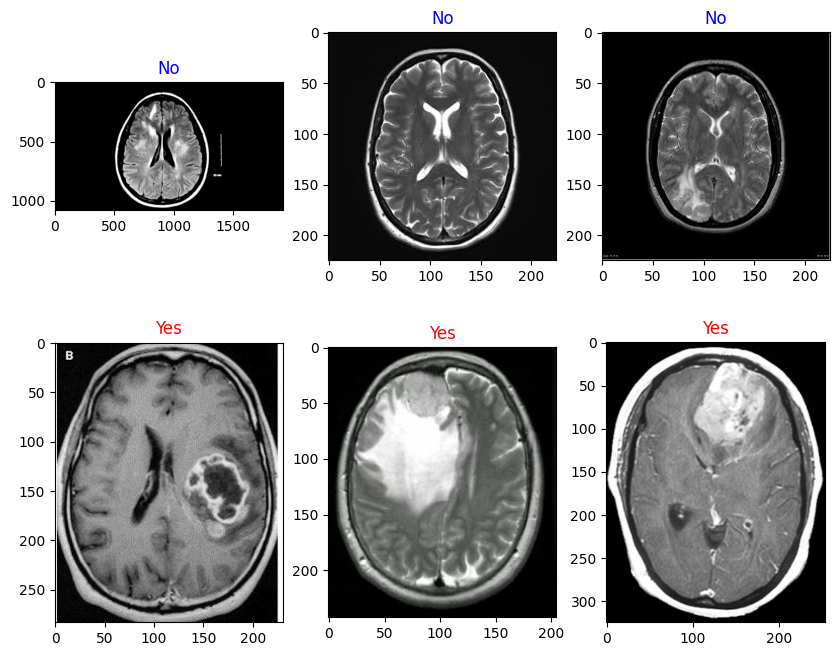

In [ ]:
%matplotlib inline

# Define the path to the dataset
IMG_PATH = 'drive/MyDrive/brain_tumor_dataset/'

# Define the labels and their corresponding colors
labels = {0: 'No', 1: 'Yes'}
colors = {0: 'blue', 1: 'red'}

# Plot some images from the train set for each label
fig, axs = plt.subplots(2, 3, figsize=(10, 8))
for i, label in enumerate([0, 1]):
    images = [x for x, y in zip(X_train, y_train) if y == label][:3]
    for j, image_path in enumerate(images):
        img = plt.imread(image_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title(labels[label], color=colors[label])
plt.show()

In [ ]:
def preprocess_images(images):
    preprocessed_images = []
    for i, img_path in enumerate(images):
        img = cv2.imread(img_path)
        img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # crop
        ADD_PIXELS = 0
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        new_img = cv2.resize(
            new_img,
            dsize=(224,224))
        preprocessed_images.append(new_img)
    return np.array(preprocessed_images)

In [ ]:
# Apply the preprocessing to all the data subsets
X_train_pre = preprocess_images(X_train)
X_val_pre = preprocess_images(X_val)
X_test_pre = preprocess_images(X_test)

In [ ]:
# Transform the subsets to numpy arrays
X_train_pre_vgg = np.array([preprocess_input(image) for image in X_train_pre])
X_val_pre_vgg = np.array([preprocess_input(image) for image in X_val_pre])
X_test_pre_vgg = np.array([preprocess_input(image) for image in X_test_pre])

# Transform the subsets to numpy arrays
X_train_pre_inception = np.array([preprocess_input(image) for image in X_train_pre])
X_val_pre_inception = np.array([preprocess_input(image) for image in X_val_pre])
X_test_pre_inception = np.array([preprocess_input(image) for image in X_test_pre])

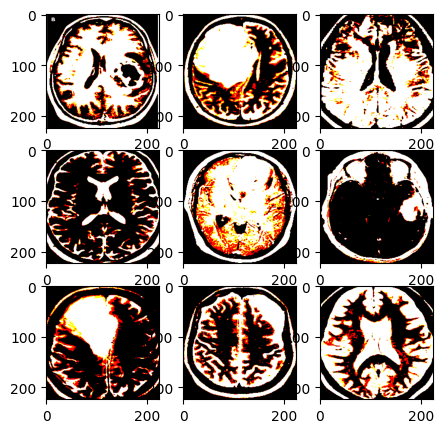

In [ ]:
# plot some images from X_train_pre
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train_pre_vgg[i], cmap='gray')
plt.show()

In [ ]:
# Load the pre-trained VGG16 and InceptionV3 models
base_model1 = VGG19(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model2 = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
x1 = base_model1.output
x1 = GlobalAveragePooling2D()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.5)(x1)
predictions1 = Dense(2, activation='sigmoid')(x1)  # Two neurons for binary classification (yes or no)

x2 = base_model2.output
x2 = GlobalAveragePooling2D()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.5)(x2)
predictions2 = Dense(2, activation='sigmoid')(x2)  # Two neurons for binary classification (yes or no)

model = Model(inputs=[base_model1.input, base_model2.input], outputs=[predictions1, predictions2])

In [ ]:
# Freeze the layers in the pre-trained models
for layer in base_model1.layers:
    layer.trainable = False

for layer in base_model2.layers:
    layer.trainable = False

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
# Data augmentation for VGG_19
datagen_vgg = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen_vgg.fit(X_train_pre_vgg)


In [ ]:
# Data augmentation for InceptionV3
datagen_inception = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen_inception.fit(X_train_pre_inception)



In [ ]:
y_train_1d = np.ravel(y_train)

# Convert y_val to 1D array
y_val_1d = np.ravel(y_val)

# Convert y_train to 2D array (one-hot encoding)
y_train_onehot = np.array([np.array([1, 0]) if label == 0 else np.array([0, 1]) for label in y_train_1d])

# Convert y_val to 2D array (one-hot encoding)
y_val_onehot = np.array([np.array([1, 0]) if label == 0 else np.array([0, 1]) for label in y_val_1d])


In [ ]:
# Early stopping
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [ ]:
import tensorflow as tf
# Define a custom data generator function
batch_size=32;
def hybrid_data_generator(X1, X2, y, batch_size):
    num_samples = X1.shape[0]
    steps_per_epoch = num_samples // batch_size
    idx = 0

    while True:
        batch_X1 = X1[idx * batch_size: (idx + 1) * batch_size]
        batch_X2 = X2[idx * batch_size: (idx + 1) * batch_size]
        batch_y = y[idx * batch_size: (idx + 1) * batch_size]

        yield [batch_X1, batch_X2], batch_y

        idx += 1
        if idx >= steps_per_epoch:
            idx = 0

# Create the data generator
train_gen = hybrid_data_generator(X_train_pre_vgg, X_train_pre_inception, y_train_onehot, batch_size)
val_data = ([X_val_pre_vgg, X_val_pre_inception], y_val_onehot)

# Train the model
epochs = 100

history = model.fit(
    train_gen,
    steps_per_epoch=len(X_train_pre_vgg) // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=val_data,
    callbacks=[early_stopping]
)



Epoch 1/100
5/5 [==============================] - 238s 50s/step - loss: 12.4678 - dense_1_loss: 1.6598 - dense_3_loss: 10.8080 - dense_1_accuracy: 0.7125 - dense_3_accuracy: 0.6562 - val_loss: 7.0261 - val_dense_1_loss: 0.7194 - val_dense_3_loss: 6.3067 - val_dense_1_accuracy: 0.8226 - val_dense_3_accuracy: 0.6452
Epoch 2/100
5/5 [==============================] - 231s 50s/step - loss: 6.1058 - dense_1_loss: 0.9847 - dense_3_loss: 5.1211 - dense_1_accuracy: 0.8125 - dense_3_accuracy: 0.6875 - val_loss: 13.9615 - val_dense_1_loss: 0.6349 - val_dense_3_loss: 13.3266 - val_dense_1_accuracy: 0.8226 - val_dense_3_accuracy: 0.6129
Epoch 3/100
5/5 [==============================] - 233s 51s/step - loss: 9.4866 - dense_1_loss: 0.5239 - dense_3_loss: 8.9627 - dense_1_accuracy: 0.8875 - dense_3_accuracy: 0.5562 - val_loss: 3.7276 - val_dense_1_loss: 0.6064 - val_dense_3_loss: 3.1213 - val_dense_1_accuracy: 0.8387 - val_dense_3_accuracy: 0.6613
Epoch 4/100
5/5 [==============================] - 

1/1 [==============================] - 10s 10s/step


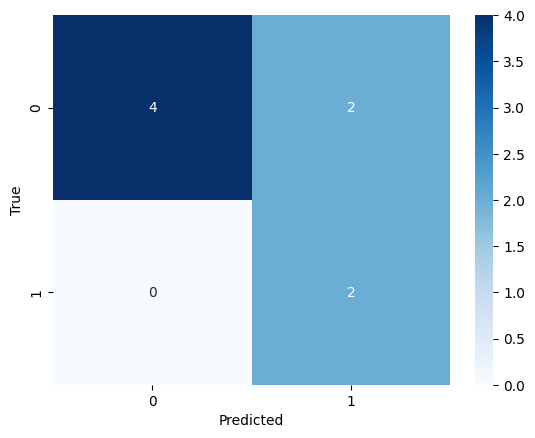

Test accuracy: 0.75


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as preprocess_input_vgg
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as preprocess_input_inception
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns  # Add this line for Seaborn



from sklearn.metrics import confusion_matrix, accuracy_score

# Make predictions on test data
y_pred_vgg, y_pred_inception = model.predict([X_test_pre_vgg, X_test_pre_inception])

# Combine the predictions from both base models (you might use different strategies to combine them)
y_pred_combined = (y_pred_vgg + y_pred_inception) / 2

# Convert the probabilities to binary predictions (0 or 1) using rounding
y_pred = np.round(y_pred_combined).argmax(axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate accuracy on test set
test_accuracy = accuracy_score(y_test, y_pred)
print('Test accuracy:', test_accuracy)